In [1]:
from src.robots.robot_helpers import build_random_robot_swarm, build_simulation_robot
from src.deployment_area.build_polygon import build_random_polygon
from src.anomaly_detectors.anomaly_detector import Coverage_Anomaly_Detector
from src.anomaly_detectors.save_load_functions import load_model
from src.anomaly_detectors.detection_methods import dm_mean
from src.anomaly_detectors.models.lstm_coupling_nf import ConditionalLSTMCouplingFlow
from src.robots.deployment_robot import VoronoiRobot, BruteForceRobot, SneakyRobot, SpoofingRobot, WeightedAggressiveRobot, WeightedRobot
import numpy as np
import matplotlib.pyplot as plt

#### set configurations

In [2]:
n_robots = np.random.randint(5, 20)
n_anomal_robots = 1

# depolyment area parameters
min_area_per_robot = 2
max_area_per_robot = 5
n_min_vertices = 3
n_max_vertices = 8

# robot parameters
max_steps = 20
sneaky_step_size = 0.1
conv_crit = 0.01

#### generate a random deployment area

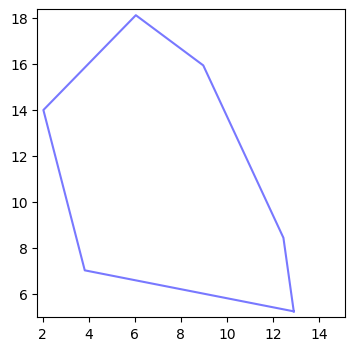

In [3]:
deployment_area = build_random_polygon(n_robots=n_robots,       min_area_per_robot=min_area_per_robot, max_area_per_robot=max_area_per_robot, n_min_vertices=n_min_vertices, n_max_vertices=n_max_vertices)

fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
deployment_area.plot_polygon(fig, ax, plot_square=True);

#### generate a robot swarm and set the swarm within the deployment area

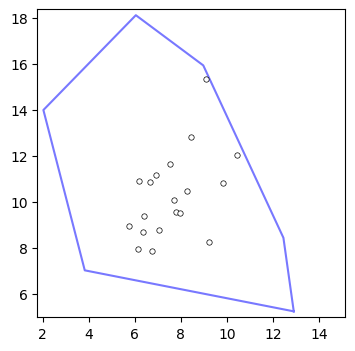

In [4]:
swarm, sensors = build_random_robot_swarm(
    deployment_area=deployment_area,
    n_robots=n_robots,
    build_robot_fn=build_simulation_robot,
    n_anomal_robots=n_anomal_robots,
    max_steps=max_steps,
    sneaky_step_size=sneaky_step_size,
    anomal_types=[SneakyRobot]
)
swarm.start_run(deployment_area=deployment_area, external_state_monitors=sensors)

fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
deployment_area.plot_polygon(fig, ax, coords=swarm.get_positions(), plot_square=True);

#### deploy robot swarm

In [5]:
await swarm.cover_area(conv_crit=conv_crit, max_steps=max_steps)
swarm.stop_run(external_state_monitors=sensors)

18 is sneaky!


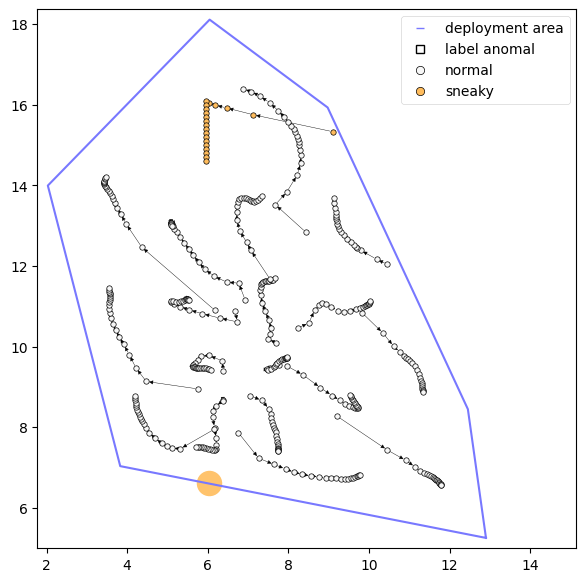

In [6]:
fig = plt.figure(figsize=(7, 7))
ax = fig.gca()
swarm.visualization_module.plot_coverage(fig, ax, plot_samples=False, plot_square=True)
plt.show();

#### load and apply anomaly detector

In [7]:
config, trained_model, _ = load_model('trained_models/lstm_coupling_nf', model_class=ConditionalLSTMCouplingFlow)

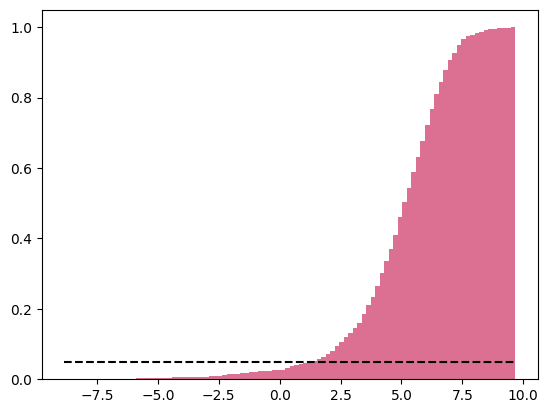

In [8]:
anomaly_detector = Coverage_Anomaly_Detector(detector=trained_model, config=config)

anomaly_detector.set_and_tune_detection_method(dm_mean(), 'simulation_data/validation_data_tune_model/', false_positive_rate=0.05)

swarm.set_anomaly_detector(anomaly_detector)
_ = anomaly_detector.evaluate_run()

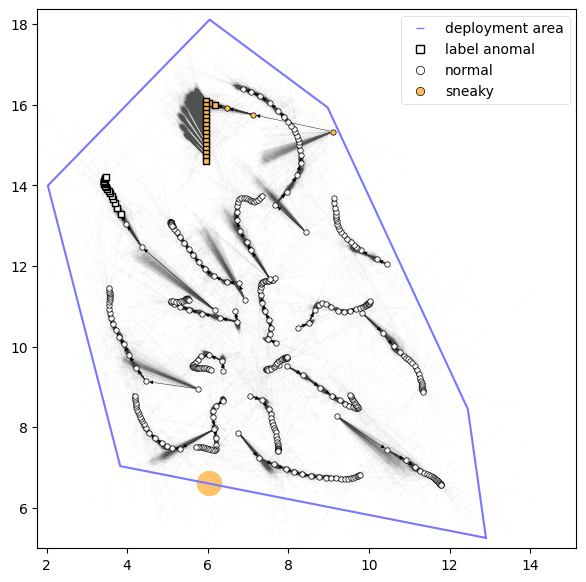

In [9]:
fig = plt.figure(figsize=(7, 7))
ax = fig.gca()
swarm.visualization_module.plot_coverage(fig, ax, plot_samples=True, plot_square=True)
plt.show();

#### move a robot

In [10]:
robot = swarm.swarm_robots[0]

print(robot._get_current_position())
vel = np.array([2, 2])
for i in range(20):
    # executed for a duration of ts_control
    robot.move_handler.trigger_movement(vel)
print(robot._get_current_position())

[ 7.65676962 11.69174926]
[ 9.19781814 13.23268059]


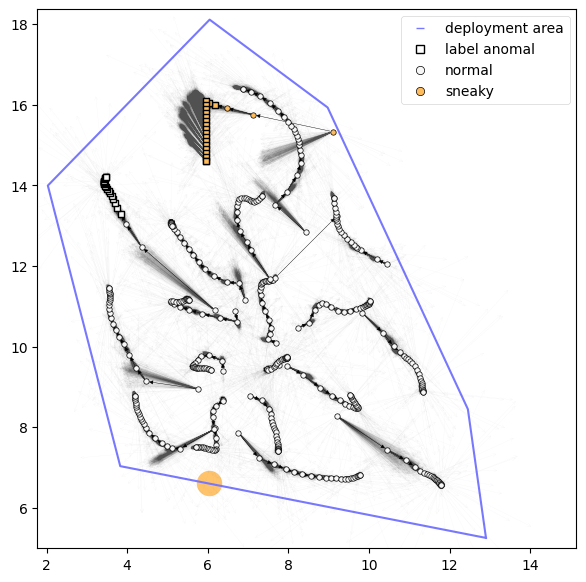

In [11]:
for robot in swarm.swarm_robots:
    robot.record_state(intermediate_state=False)

fig = plt.figure(figsize=(7, 7))
ax = fig.gca()
_ = anomaly_detector.evaluate_run()
swarm.visualization_module.plot_coverage(fig, ax, plot_samples=True, plot_square=True)
plt.show();